# imports

In [1]:
## Helper
def initialize_model(use_resnet=True, pretrained=False, nclasses=10):
    """
    
    """
    ## Initialize Model
    if use_resnet:
        model = resnet50(pretrained=pretrained)
    else:
        model = vgg16(pretrained=True)
    ## Freeze Early Layers if Pretrained
    if pretrained:
        for parameter in model.parameters():
            parameter.requires_grad = False
    ## Update Output Layer
    if use_resnet:
        model.fc = torch.nn.Linear(2048, nclasses)
    else:
        model.classifier._modules['6'] = torch.nn.Linear(4096, nclasses)
    return model

In [96]:
import random
import torch
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VisionDataset
import os
import time
import matplotlib.pyplot as plt
from skimage import io, color
import numpy as np
import pandas as pd
import warnings
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import extract_archive, check_integrity, download_url, verify_str_arg

In [3]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [14]:
#data_path = '/content/gdrive/MyDrive/tiny-imagenet-200'
data_path = '/content/gdrive/MyDrive/Colab Notebooks/deep learning/final/tiny-imagenet-200'
directory_path = '/content/gdrive/MyDrive/Colab Notebooks/deep learning/final/pretrained'
model_path = '/content/gdrive/MyDrive/Colab Notebooks/deep learning/final/pretrained'
# data_root = 'tiny-imagenet-200'

# DATA preparation

original size:

200 classes

train: 200*500

val: 10,000

test: 10,000

for train data, sample 50(10%)/5(1%) images from each class

val data are used to tune

test data to test


In [85]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-05-07 16:17:08--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.1’

tiny-imagenet-200.z 100%[===================>] 236.61M  11.2MB/s    in 21s     

2021-05-07 16:17:29 (11.5 MB/s) - ‘tiny-imagenet-200.zip.1’ saved [248100043/248100043]



In [86]:
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tiny-imagenet-200/wnids.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tiny-imagenet-200/test/images/test_1860.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tiny-imagenet-200/test/images/test_613.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n
n
A
test  train  val  wnids.txt  words.txt


In [127]:
# adopted from https://github.com/lvyilin/pytorch-fgvc-dataset/blob/master/tiny_imagenet.py
class TinyImageNet(VisionDataset):
    """`tiny-imageNet <http://cs231n.stanford.edu/tiny-imagenet-200.zip>`_ Dataset.
        Args:
            root (string): Root directory of the dataset.
            split (string, optional): The dataset split, supports ``train``, or ``val``.
            transform (callable, optional): A function/transform that  takes in an PIL image
               and returns a transformed version. E.g, ``transforms.RandomCrop``
            target_transform (callable, optional): A function/transform that takes in the
               target and transforms it.
            download (bool, optional): If true, downloads the dataset from the internet and
               puts it in root directory. If dataset is already downloaded, it is not
               downloaded again.
    """
    base_folder = 'tiny-imagenet-200/'
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    filename = 'tiny-imagenet-200.zip'
    md5 = '90528d7ca1a48142e341f4ef8d21d0de'

    def __init__(self, root, split='train', transform=None, target_transform=None, download=False, percent=0.1):
        super(TinyImageNet, self).__init__(root, transform=transform, target_transform=target_transform)

        self.dataset_path = os.path.join(root, self.base_folder)
        self.loader = default_loader
        self.split = verify_str_arg(split, "split", ("train", "val",))
        self.percent = percent
        self.transform = transforms.Compose([
            transforms.Resize(256, Image.BILINEAR),
            transforms.CenterCrop(255)])
    
        self.__augment_tile = transforms.Compose([
            transforms.RandomCrop(64),
            transforms.Resize((75, 75), Image.BILINEAR),
            transforms.Lambda(rgb_jittering),
            transforms.ToTensor(),

        ])
        '''
        if self._check_integrity():
            print('Files already downloaded and verified.')
        elif download:
            self._download()
        else:
            raise RuntimeError(
                'Dataset not found. You can use download=True to download it.')
        '''
        if not os.path.isdir(self.dataset_path):
            print('Extracting...')
            extract_archive(os.path.join(root, self.filename))

        _, class_to_idx = find_classes(os.path.join(self.dataset_path, 'wnids.txt'))

        self.data = make_dataset(self.root, self.base_folder, self.split, class_to_idx, self.percent)

    def _download(self):
        print('Downloading...')
        download_url(self.url, root=self.root, filename=self.filename)
        print('Extracting...')
        extract_archive(os.path.join(self.root, self.filename))

    def _check_integrity(self):
        return check_integrity(os.path.join(self.root, self.filename), self.md5)

    def __getitem__(self, index):
        img_path, target = self.data[index]
        image = self.loader(img_path)

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)


        s = (image.size[0]) / 3
        a = s / 2
        tiles = [None] * 9
        n = 0
        for i in range(3):
          for j in range(3):

            c = np.array([i*85,j*85,i*85+85,j*85+85]).astype(int)
  
            tile = image.crop(c.tolist())

            tile = self.__augment_tile(tile)

            # Normalize the patches indipendently to avoid low level features shortcut
            m, s = tile.view(3, -1).mean(dim=1).numpy(), tile.view(3, -1).std(dim=1).numpy()
            s[s == 0] = 1
            norm = transforms.Normalize(mean=m.tolist(), std=s.tolist())
            #tile = norm(tile)

            tiles[n] = tile
            n+=1

 
        data = [tiles[t] for t in range(9)]
        data = torch.stack(data, 0)

        return data, target

    def __len__(self):
        return len(self.data)


def find_classes(class_file):
    with open(class_file) as r:
        classes = list(map(lambda s: s.strip(), r.readlines()))

    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}

    return classes, class_to_idx


def make_dataset(root, base_folder, dirname, class_to_idx, percent=1):
    images = []
    dir_path = os.path.join(root, base_folder, dirname)

    if dirname == 'train':
        for fname in sorted(os.listdir(dir_path)):
            cls_fpath = os.path.join(dir_path, fname)
            if os.path.isdir(cls_fpath):
                cls_imgs_path = os.path.join(cls_fpath, 'images')
                image_names = os.listdir(cls_imgs_path)
                image_number = len(image_names)
                smaple_image_names = random.sample(image_names, int(image_number*percent))
                for imgname in sorted(smaple_image_names):
                    path = os.path.join(cls_imgs_path, imgname)
                    item = (path, class_to_idx[fname])
                    images.append(item)
    else:
        imgs_path = os.path.join(dir_path, 'images')
        imgs_annotations = os.path.join(dir_path, 'val_annotations.txt')

        with open(imgs_annotations) as r:
            data_info = map(lambda s: s.split('\t'), r.readlines())

        cls_map = {line_data[0]: line_data[1] for line_data in data_info}
        image_names = os.listdir(imgs_path)
        image_number = len(image_names)
        smaple_image_names = random.sample(image_names, int(image_number*percent))
        for imgname in smaple_image_names:
            path = os.path.join(imgs_path, imgname)
            item = (path, class_to_idx[cls_map[imgname]])
            images.append(item)

    return images

In [101]:
norm = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# data augmentation to training data
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), norm])
test_transform = transforms.Compose([transforms.ToTensor(), norm])

In [128]:
train_dataset = TinyImageNet('.', split='train', download=False, transform=train_transform, percent = 0.1)
val_dataset = TinyImageNet('.', split='val', download=False, transform=test_transform)
# test_dataset = TinyImageNet('.', split='test', download=False, transform=test_transform)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [129]:
batch_size=128
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,  shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True)

In [130]:
print(len(val_dataset))
print(len(train_dataset))

1000
10000


In [131]:
for image, label in train_dataset:
  print(image.shape)
  break

torch.Size([9, 3, 75, 75])


tensor([180,  21,  75,  45,  60, 173,  65, 165,  16,  31,  48,  28,  25,  55,
        152, 108, 128,  81, 102,  36,  45,  37,  24, 179, 161, 172, 122, 176,
        119, 177,   5,  57, 122, 168,  50,  51,  35,   5,  11, 120,  67,  32,
         94, 106, 166,  20, 146, 187,  42, 174,  58, 179, 126, 150, 199,  98,
          4, 180, 173, 150,  62,  93, 160, 123, 127, 196,   6,  45,  98,  36,
         94,  60, 194, 129, 116, 132,  22,  94, 121, 107, 176,  45, 199, 130,
         96,  15, 112, 105,  47, 131, 173,   7, 160, 146,  30, 159,  48,  51,
        183, 178,  46, 113, 158,  52,  39, 126,  20, 113,  75,  63,  79, 160,
         79,  66, 129, 151,  37,  15,  41,  98, 131, 112, 108,  64,  61, 165,
         88,  89])


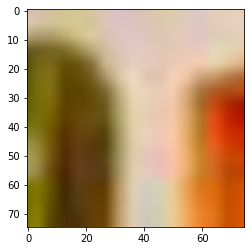

In [133]:
for image, label in train_dataloader:
  print(label)
  plt.imshow(image[0][0].permute(1, 2, 0))
  break

# Initialize + Load Pretrained

In [29]:
import torch
import torch.nn as nn
from torch import cat
import torch.nn.init as init

import sys
#sys.path.append('Utils')
#from Layers import LRN

import torchvision.models as models



class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=True):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1),
                    stride=1,padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta


    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x
class JigResnet(nn.Module):

    def __init__(self, classes=1000):
        super(JigResnet, self).__init__()
        self.resnet18 = models.resnet18()
        #self.resnet50 = models.resnet50()
        self.conv = nn.Sequential()
        self.conv.add_module('conv1_s1',nn.Conv2d(3, 96, kernel_size=11, stride=2, padding=0))
        self.conv.add_module('relu1_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool1_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn1_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv2_s1',nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2))
        self.conv.add_module('relu2_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool2_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn2_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv3_s1',nn.Conv2d(256, 384, kernel_size=3, padding=1))
        self.conv.add_module('relu3_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv4_s1',nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu4_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv5_s1',nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu5_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool5_s1',nn.MaxPool2d(kernel_size=3, stride=2))

        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(256*3*3, 1024))
        self.fc6.add_module('relu6_s1',nn.ReLU(inplace=True))
        self.fc6.add_module('drop6_s1',nn.Dropout(p=0.5))

        self.fc7 = nn.Sequential()
        self.fc7.add_module('fc7',nn.Linear(9*1000,4096))
        self.fc7.add_module('relu7',nn.ReLU(inplace=True))
        self.fc7.add_module('drop7',nn.Dropout(p=0.5))

        self.classifier = nn.Sequential()
        self.classifier.add_module('fc8',nn.Linear(4096, classes))
        
        #self.apply(weights_init)

    def load(self,checkpoint):
        model_dict = self.state_dict()
        pretrained_dict = torch.load(checkpoint)
        pretrained_dict = {k: v for k, v in list(pretrained_dict.items()) if k in model_dict and 'fc8' not in k}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        print([k for k, v in list(pretrained_dict.items())])

    def save(self,checkpoint):
        torch.save(self.state_dict(), checkpoint)
    
    def forward(self, x):
 
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(9):
            z = self.resnet18(x[i])
            #z = self.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = self.fc7(x.view(B,-1))
        x = self.classifier(x)

        return x


def weights_init(model):
    if type(model) in [nn.Conv2d,nn.Linear]:
        nn.init.xavier_normal(model.weight.data)
        nn.init.constant(model.bias.data, 0.1)
    




In [187]:
model = JigResnet()
model.load_state_dict(torch.load(model_path + "/JigResnet18"))

<All keys matched successfully>

In [188]:
for param in model.parameters():
    #print(param.requires_grad)
    param.requires_grad = False
    #print(param.requires_grad)
    


for param in model.classifier.parameters():
  #print(param.requires_grad)
  param.requires_grad = True

In [189]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


# train function

In [182]:
def test_eval(verbose = 1):
    correct = 0
    five_correct = 0
    total = 0
    loss_sum = 0
    for images, labels in val_dataloader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        # images = images.view(-1, 64*64)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        _, five_predicted = outputs.data.topk(5, 1, True, True)
        five_predicted = five_predicted.t()
        five_y = five_predicted.eq(labels.view(1, -1).expand_as(five_predicted))

        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()
        five_correct += (five_predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Top1 Test accuracy: %f %%' % (100.0 * correct / total))
        print('Top5 Test accuracy: %f %%' % (100.0 * five_correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total



In [139]:
def adjust_learning_rate(optimizer, epoch, init_lr=0.1, step=30, decay=0.1):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (decay ** (epoch // step))
    print('Learning Rate %f'%lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [190]:
def train(net,
          optimizer,
          loss_metric,
          scheduler,
          epochs = 10,
          load_model_path = None,
          save_model_name = 'resnet-tiny-10-Jigsaw.pth',
          save_data_name = 'resnet-tiny-10-Jigsaw_data.npz',
          init_lr = 0.05
          ):
  
  if load_model_path:
    print('load trained model')
    state_dict = torch.load(load_model_path)
    net.load_state_dict(state_dict)

  #define batch train loss recording array for later visualization/plotting:
  loss_store = []
  train_perc_store = []
  test_perc_store = [] 
  test_loss_store = []
  best_test_perc = 0
  print("Starting Training")
  #training loop:
  for epoch in range(epochs):

      if epoch % 5 == 0 and epoch != 0:
        lr = adjust_learning_rate(optimizer, epoch, init_lr=init_lr, step=5, decay=0.5)

      time1 = time.time() #timekeeping

      net.train()
      total = 0
      correct = 0
      five_correct = 0
      train_loss = 0
      for i, (x,y) in enumerate(train_dataloader):

          if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

          # x = x.view(x.shape[0],-1)
          #loss calculation and gradient update:

          if i > 0 or epoch > 0:
              optimizer.zero_grad()
          #print(x.shape)
          outputs = net.forward(x)
          _, one_predicted = torch.max(outputs.data, 1)
          _, five_predicted = outputs.data.topk(5, 1, True, True)


          five_predicted = five_predicted.t()
          five_y = five_predicted.eq(y.view(1, -1).expand_as(five_predicted))

          #print(five_predicted)
          #print(five_predicted == y)
          total += y.size(0)
          correct += (one_predicted.float() == y.float()).sum()
          five_correct += (five_predicted.float() == y.float()).sum()
          #print((five_predicted.float() == y.float()).sum(0))
          loss = loss_metric(outputs,y)
          train_loss += loss.cpu().data.numpy().item()
          loss.backward()

          ##perform update:
          optimizer.step()

      print("Epoch",epoch+1,':')
      # train
      print('Top 1 Train accuracy: %f %%' % (100.0 * correct / total))
      print('Top 5 Train accuracy: %f %%' % (100.0 * five_correct / total))
      print('Train loss: %f' % (train_loss/total))
      loss_store.append(train_loss/total)
      train_perc = 100.0 * correct / total
      train_perc_store.append(train_perc.cpu().data.numpy().item())
      net.eval()
      # test
      test_perc, test_loss = test_eval()
      test_loss_store.append(test_loss)
      test_perc_store.append(test_perc.cpu().data.numpy().item())
      # save the model with highest acc on test set
      if test_perc > best_test_perc:
        best_test_perc = test_perc
        torch.save(net.state_dict(), os.path.join(directory_path, save_model_name ))
        print('new best test acc at', epoch+1)

      scheduler.step()
      time2 = time.time() #timekeeping
      print('Elapsed time for epoch:',time2 - time1,'s')
      print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
      print()

      # save data
      save_filename = os.path.join(directory_path, save_data_name)
      np.savez(save_filename, train_perc=train_perc_store,  train_loss=loss_store, test_perc=test_perc_store, test_loss=test_loss_store)


# train start

In [191]:
## Get Model
## 50 + 50 + 50

net = model
#lr = 0.05
#lr = 0.003125/2
lr = 0.05
if torch.cuda.is_available:
  net = net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
train_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975) 
loss_metric = torch.nn.CrossEntropyLoss()
train(net,
      optimizer,
      loss_metric,
      train_scheduler,
      epochs = 100,
      save_model_name = 'simclr_entire.pth',
      save_data_name = 'simclr_entire_data.pth',
      init_lr = lr
      )

Starting Training
Epoch 1 :
Top 1 Train accuracy: 0.810000 %
Top 5 Train accuracy: 3.300000 %
Train loss: 0.158977
Top1 Test accuracy: 0.800000 %
Top5 Test accuracy: 4.700000 %
Test loss: 0.219041
new best test acc at 1
Elapsed time for epoch: 80.43292188644409 s
ETA of completion: 132.71432111263275 minutes

Epoch 2 :
Top 1 Train accuracy: 1.130000 %
Top 5 Train accuracy: 4.600000 %
Train loss: 0.226771
Top1 Test accuracy: 1.700000 %
Top5 Test accuracy: 4.300000 %
Test loss: 0.242055
new best test acc at 2
Elapsed time for epoch: 81.47997283935547 s
ETA of completion: 133.08395563761394 minutes

Epoch 3 :
Top 1 Train accuracy: 1.150000 %
Top 5 Train accuracy: 4.730000 %
Train loss: 0.247041
Top1 Test accuracy: 1.000000 %
Top5 Test accuracy: 4.200000 %
Test loss: 0.251276
Elapsed time for epoch: 81.20045852661133 s
ETA of completion: 131.27407461802164 minutes

Epoch 4 :
Top 1 Train accuracy: 1.570000 %
Top 5 Train accuracy: 5.510000 %
Train loss: 0.254553
Top1 Test accuracy: 0.500000 

# train more

#plot

In [1]:
def plot_data(filepath):
    data = np.load(filepath)

    if 'train_perc' in data:
        plt.plot(data['train_perc'],label = 'train precision')
        plt.xlabel('epoch Number')
    plt.ylabel('train/val precision at each epoch')
    plt.legend()
    plt.show()    
    if 'test_perc' in data:
        plt.plot(data['test_perc'], label = 'validation precision')
        plt.xlabel('epoch Number')
    plt.ylabel('train/val precision at each epoch')
    plt.legend()
    plt.show()

    if 'train_loss' in data:
        plt.plot(data['train_loss'], label = 'train loss')
        plt.xlabel('epoch Number')
    if 'test_loss' in data:
        plt.plot(data['test_loss'], label = 'validation loss')
        plt.xlabel('epoch Number')
    plt.ylabel('train/val loss at each epoch')
    plt.legend()
    plt.show()

In [ ]:
plot_data(directory_path+'/simclr_entire_data.pth.npz')